# 프로젝트명 : 4주차 제조데이터 실습코드

### 📌 프로젝트 소개

- 다이캐스팅은 액체화된 금속을 주조(틀, Frame)에 넣고 원하는 모양의 금속부품을 생산하는 방법입니다.
- 다이캐스팅에서는 주요 4대 요소인 압력, 속도, 시간, 온도에 대해서 조건관리를 중요 시 합니다.

### 📝 현장에서 온 정보
- 데이터 제공기업의 경우 일일 또는 주간 단위로 품질 이슈 현황을 파악하고 있으며 불량원인을 수작업으로 분석하고 있습니다.
- 각 불량에 대한 발생원인과 대책이 정의되어 있으나 이를 적용하여 해결하지 못하고 있는 실정입니다.
- 대부분의 중소기업에서는 관리자 및 작업자의 경험에 의해 설비를 운용하고 있어 체계적인 관리를 하지 못하고 있기 때문입니다.
- 따라서 일정한 공정 환경 및 공정 변수를 관리해 불량에 대응하는 것이 필요합니다.


#### 다이캐스팅

![다이캐스팅](https://firebasestorage.googleapis.com/v0/b/ls-storage-e452a.appspot.com/o/%E1%84%83%E1%85%A1%E1%84%8B%E1%85%B5%E1%84%8F%E1%85%A2%E1%84%89%E1%85%B3%E1%84%90%E1%85%B5%E1%86%BC.gif?alt=media&token=70587460-34c3-4a67-a056-f7a5e6ad8521)

In [3]:
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings('ignore')

casting = pd.read_csv("https://firebasestorage.googleapis.com/v0/b/ls-storage-e452a.appspot.com/o/casting.csv?alt=media&token=54fffc33-03ad-4431-8e20-34ede32c043f", 
                      encoding='cp949',
                      index_col=0)

In [4]:
casting.head()

,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:06,258,가동,ON,731.0,119,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:08,243,가동,ON,720.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:08,0.0,NaN,8412,B
2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:58,244,가동,ON,721.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:58,0.0,NaN,8412,B
3,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:48:03,245,가동,ON,721.0,100,...,NaN,483.0,0.0,30.0,25,2019-01-02 16:48:03,0.0,NaN,8412,B
4,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:50:08,246,가동,ON,721.0,99,...,NaN,486.0,0.0,30.0,25,2019-01-02 16:50:08,0.0,NaN,8412,B


# 1. 데이터 준비

In [5]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import xgboost
import lightgbm
import warnings
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
warnings.filterwarnings('ignore')

In [7]:
data = casting

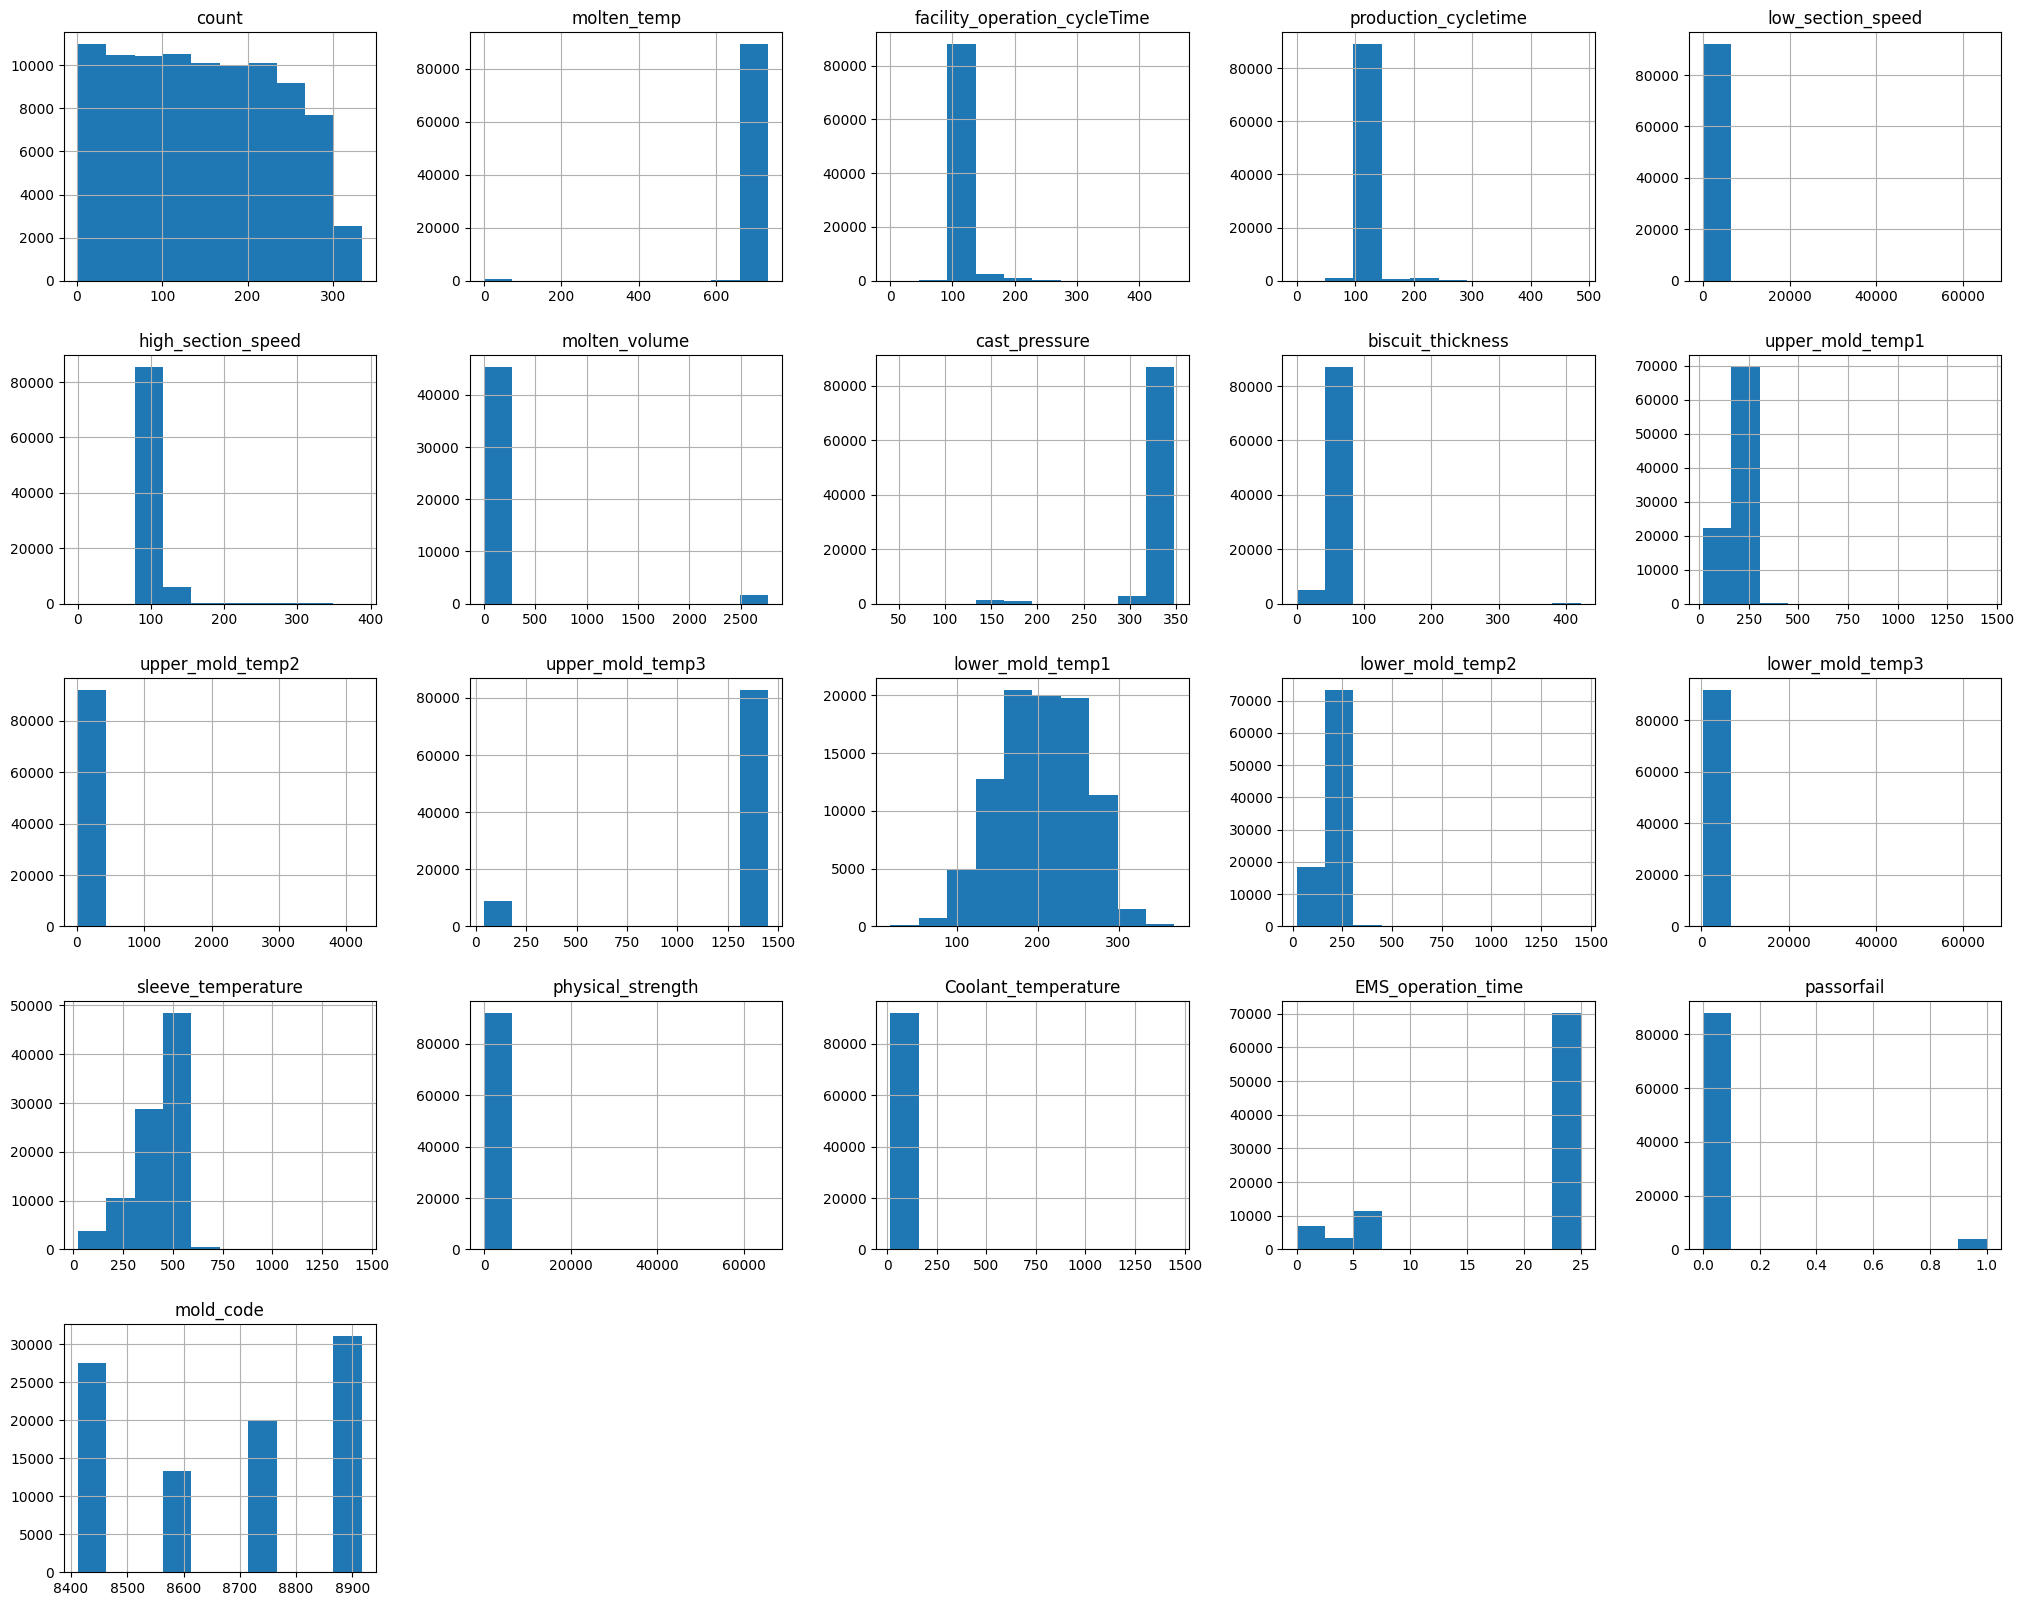

In [73]:
data.hist(figsize=(25,20))
plt.show()

In [74]:
pass_count = len(data[data['passorfail']== 0])
fail_count = len(data[data['passorfail']== 1])
                 
print('양품 개수 : ', pass_count)
print('불량 개수 : ', fail_count)
print('불량률 :', fail_count/(fail_count+pass_count)*100)

양품 개수 :  87998
불량 개수 :  4016
불량률 : 4.364553220162149


In [8]:
data_copy = casting.copy()

In [76]:
print(data_copy['mold_code'].value_counts)

<bound method IndexOpsMixin.value_counts of 0        8722
1        8412
2        8412
3        8412
4        8412
         ... 
92010    8917
92011    8917
92012    8917
92013    8917
92014    8917
Name: mold_code, Length: 92015, dtype: int64>


# 2. 데이터 탐색

### 2-1. 온도 변수 시각화

- 온도 비교 : 박스플롯, 산점도
- 1 : upper_mold_temp1, upper_mold_temp2, upper_mold_temp3
- 2 : lower_mold_temp1, lower_mold_temp2, lower_mold_temp3
- 3 : sleeve_temperature, Coolant_temperature

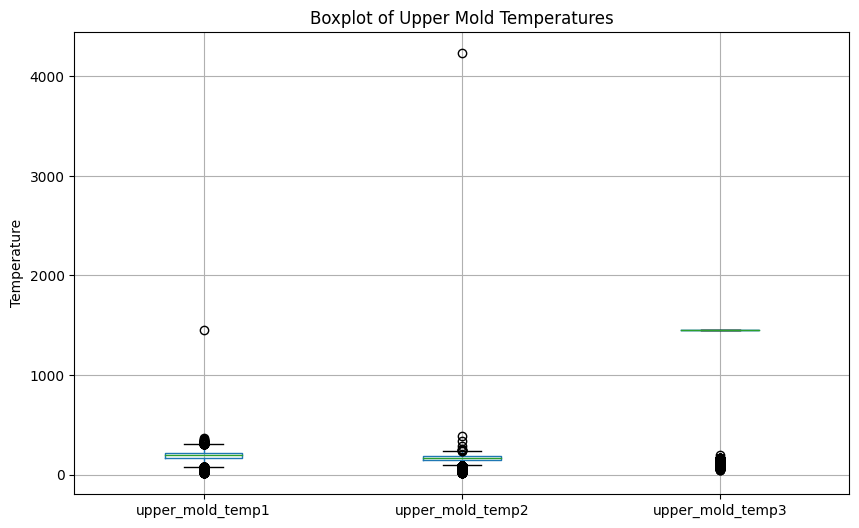

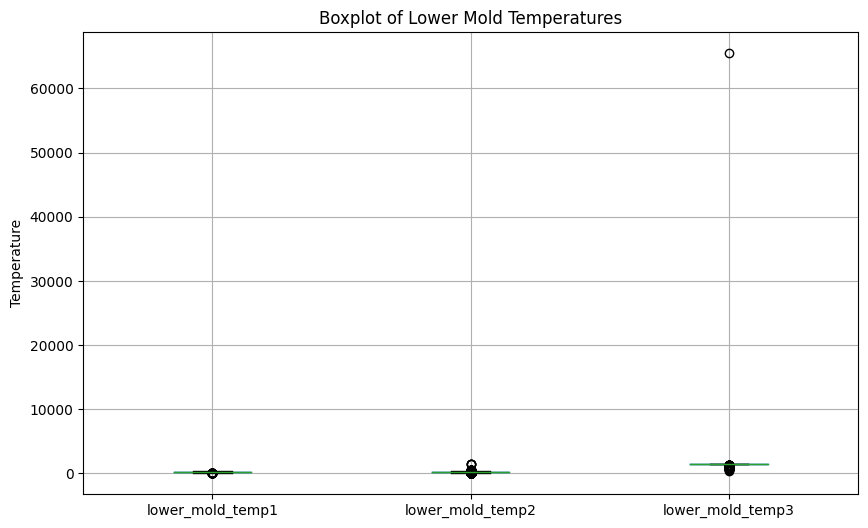

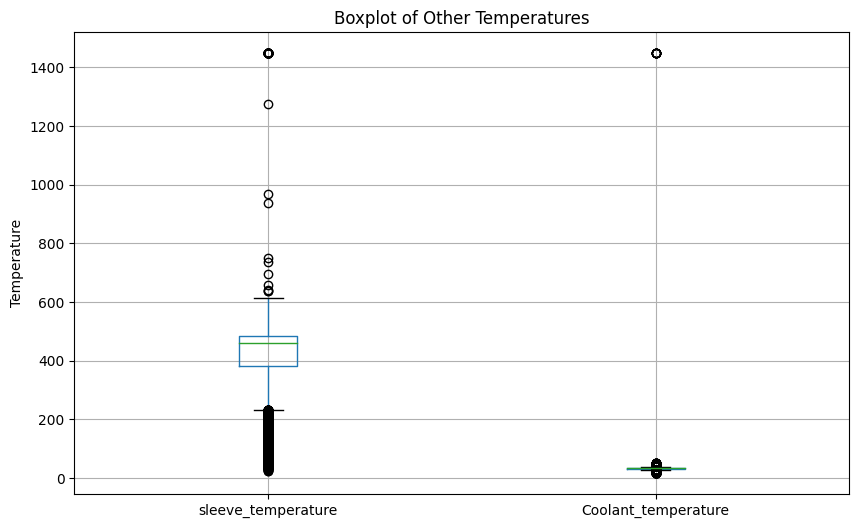

In [337]:
# upper_mold_temp1, upper_mold_temp2, upper_mold_temp3의 박스플롯을 그립니다.
plt.figure(figsize=(10, 6))
data_copy[['upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3']].boxplot()
plt.title('Boxplot of Upper Mold Temperatures')
plt.ylabel('Temperature')
plt.show()

# lower_mold_temp1, lower_mold_temp2, lower_mold_temp3의 박스플롯을 그립니다.
plt.figure(figsize=(10, 6))
data_copy[['lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3']].boxplot()
plt.title('Boxplot of Lower Mold Temperatures')
plt.ylabel('Temperature')
plt.show()

# sleeve_temperature, Coolant_temperature의 박스플롯을 그립니다.
plt.figure(figsize=(10, 6))
data_copy[['sleeve_temperature', 'Coolant_temperature']].boxplot()
plt.title('Boxplot of Other Temperatures')
plt.ylabel('Temperature')
plt.show()

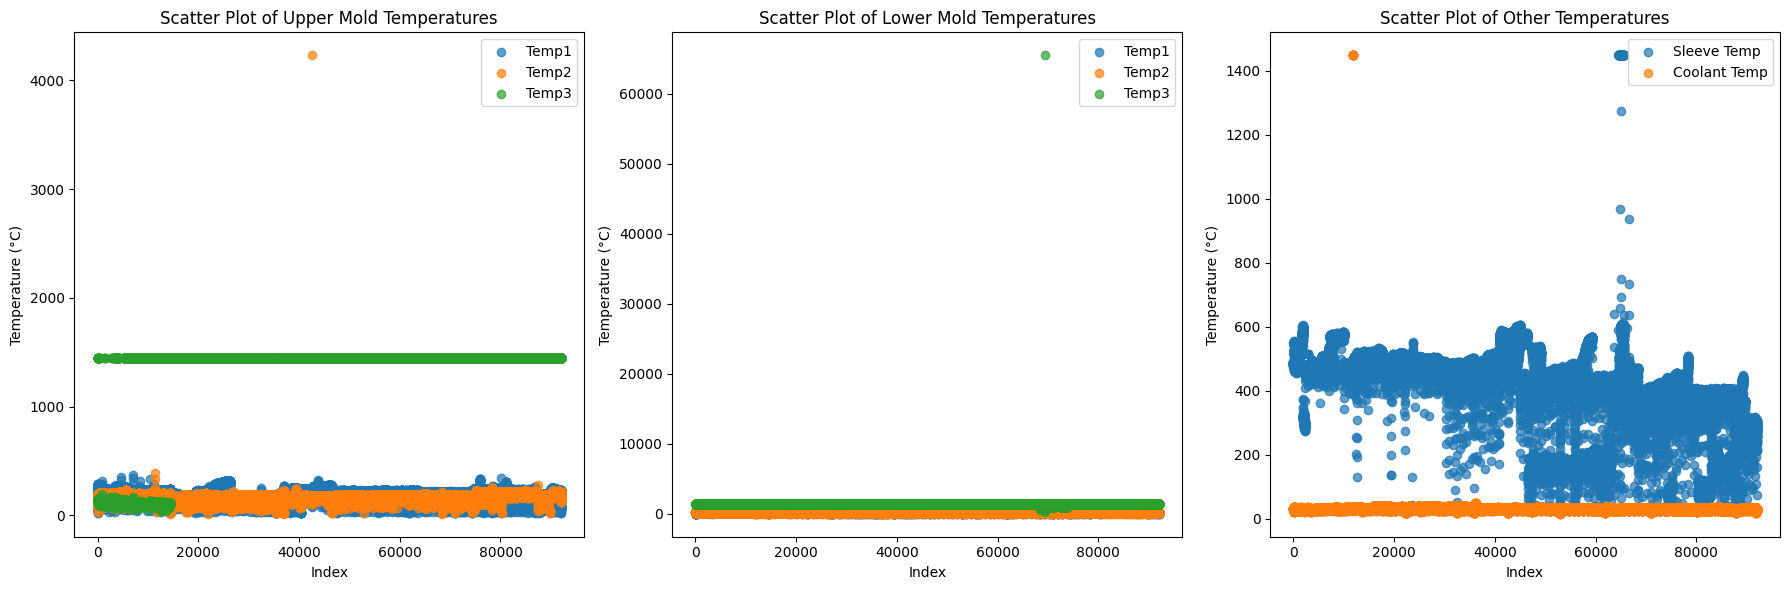

In [338]:
# 한 행에 세 개의 산점도를 나란히 그립니다.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Upper mold temperatures
axs[0].scatter(data_copy.index, data_copy['upper_mold_temp1'], label='Temp1', alpha=0.7)
axs[0].scatter(data_copy.index, data_copy['upper_mold_temp2'], label='Temp2', alpha=0.7)
axs[0].scatter(data_copy.index, data_copy['upper_mold_temp3'], label='Temp3', alpha=0.7)
axs[0].set_title('Scatter Plot of Upper Mold Temperatures')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_xlabel('Index')
axs[0].legend()

# Lower mold temperatures
axs[1].scatter(data_copy.index, data_copy['lower_mold_temp1'], label='Temp1', alpha=0.7)
axs[1].scatter(data_copy.index, data_copy['lower_mold_temp2'], label='Temp2', alpha=0.7)
axs[1].scatter(data_copy.index, data_copy['lower_mold_temp3'], label='Temp3', alpha=0.7)
axs[1].set_title('Scatter Plot of Lower Mold Temperatures')
axs[1].set_ylabel('Temperature (°C)')
axs[1].set_xlabel('Index')
axs[1].legend()

# Sleeve and Coolant temperatures
axs[2].scatter(data_copy.index, data_copy['sleeve_temperature'], label='Sleeve Temp', alpha=0.7)
axs[2].scatter(data_copy.index, data_copy['Coolant_temperature'], label='Coolant Temp', alpha=0.7)
axs[2].set_title('Scatter Plot of Other Temperatures')
axs[2].set_ylabel('Temperature (°C)')
axs[2].set_xlabel('Index')
axs[2].legend()

plt.tight_layout()
plt.show()

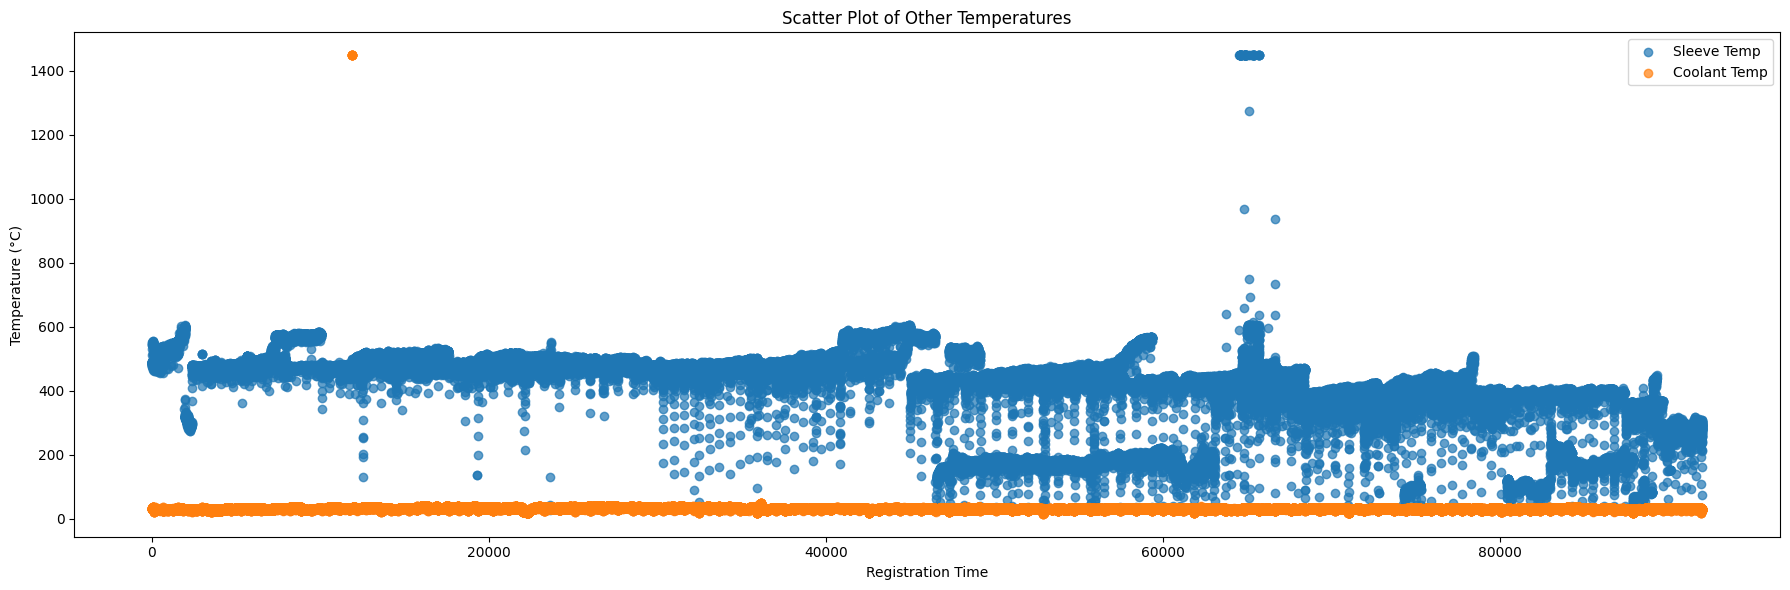

In [340]:
# registration_time 열을 인덱스로 설정합니다.

# 한 행에 세 개의 산점도를 나란히 그립니다.
plt.subplots(figsize=(18, 6))

# Sleeve and Coolant temperatures
plt.scatter(data_copy.index, data_copy['sleeve_temperature'], label='Sleeve Temp', alpha=0.7)
plt.scatter(data_copy.index, data_copy['Coolant_temperature'], label='Coolant Temp', alpha=0.7)
plt.title('Scatter Plot of Other Temperatures')  # set_title이 아니라 title입니다.
plt.ylabel('Temperature (°C)')  # set_ylabel이 아니라 ylabel입니다.
plt.xlabel('Registration Time')  # set_xlabel이 아니라 xlabel입니다.
plt.legend()

plt.tight_layout()
plt.show()


## 2-2. 온도/압력 변수 시각화 : spec 확인용

                       Counts       Proportions          
passorfail                0.0   1.0         0.0       1.0
upper_mold_temp1_range                                   
0-50                       24   308    0.072289  0.927711
50-100                    421   771    0.353188  0.646812
100-150                 15279  1290    0.922144  0.077856
150-200                 33112  1053    0.969179  0.030821
200-250                 36523   550    0.985164  0.014836
250-300                  2327    37    0.984349  0.015651


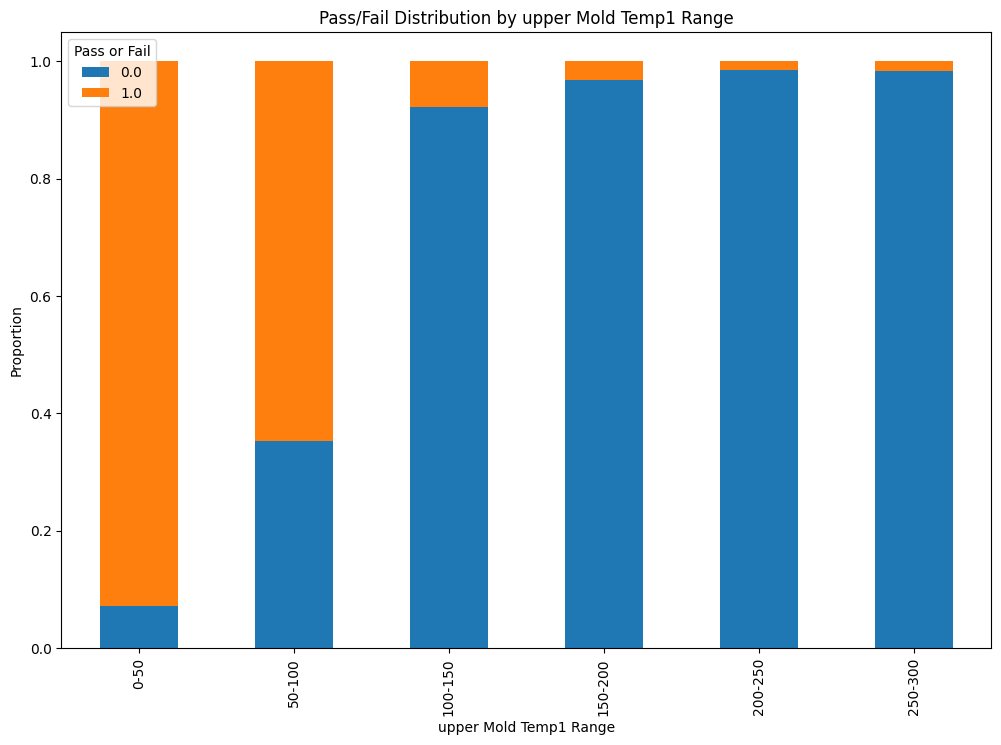

In [87]:
# upper_mold_temp1의 범위 설정
bins = [0, 50, 100, 150, 200, 250, 300]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300']

# lower_mold_temp1을 범위로 변환
data_copy['upper_mold_temp1_range'] = pd.cut(data_copy['upper_mold_temp1'], bins=bins, labels=labels)

# 범위별 passorfail의 비율 계산
passorfail_counts = data_copy.groupby('upper_mold_temp1_range')['passorfail'].value_counts(normalize=True).unstack().fillna(0)

# 범위별 passorfail의 비율 숫자로 출력
passorfail_counts_numeric = data_copy.groupby('upper_mold_temp1_range')['passorfail'].value_counts().unstack().fillna(0)

# 숫자와 비율을 함께 출력
passorfail_summary = pd.concat([passorfail_counts_numeric, passorfail_counts], axis=1, keys=['Counts', 'Proportions'])

print(passorfail_summary)

# 시각화
passorfail_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Pass/Fail Distribution by upper Mold Temp1 Range')
plt.xlabel('upper Mold Temp1 Range')
plt.ylabel('Proportion')
plt.legend(title='Pass or Fail')
plt.show()

                   Counts       Proportions          
passorfail            0.0   1.0         0.0       1.0
high_section_speed                                   
0-50                    0    22    0.000000  1.000000
50-100                 53     6    0.898305  0.101695
100-150             87648  3771    0.958750  0.041250
150-200               254    31    0.891228  0.108772
200-250                26   114    0.185714  0.814286
250-300                13    39    0.250000  0.750000


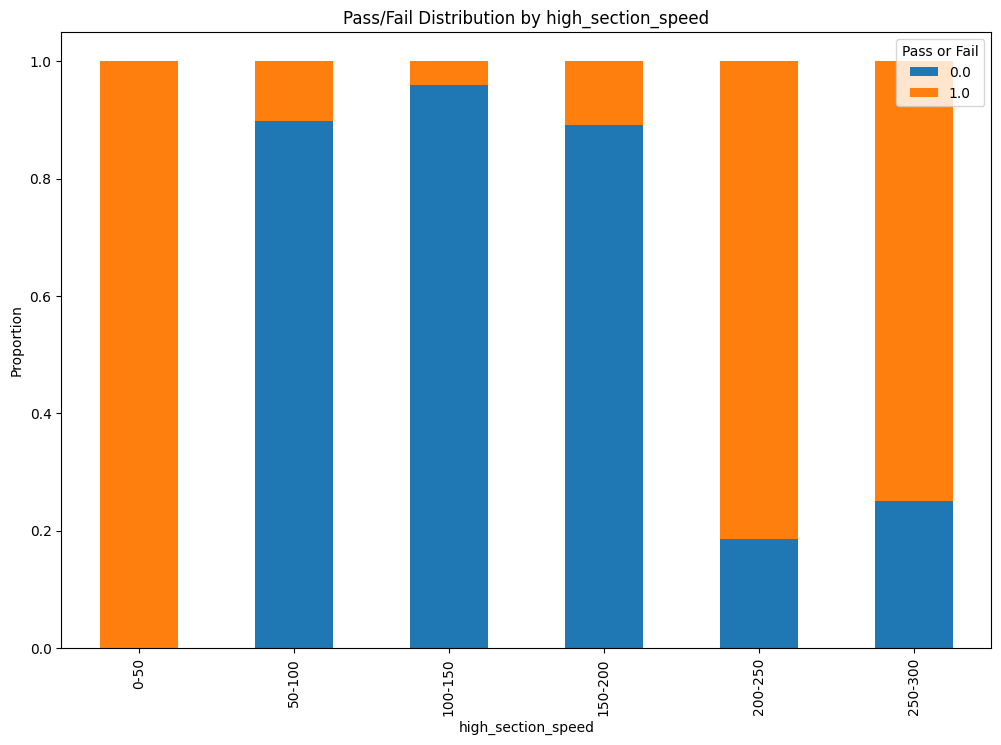

In [88]:
# high_section_speed의 범위 설정
bins = [0, 50, 100, 150, 200, 250, 300]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300']

# lower_mold_temp1을 범위로 변환
data_copy['high_section_speed'] = pd.cut(data_copy['high_section_speed'], bins=bins, labels=labels)

# 범위별 passorfail의 비율 계산
passorfail_counts = data_copy.groupby('high_section_speed')['passorfail'].value_counts(normalize=True).unstack().fillna(0)

# 범위별 passorfail의 비율 숫자로 출력
passorfail_counts_numeric = data_copy.groupby('high_section_speed')['passorfail'].value_counts().unstack().fillna(0)

# 숫자와 비율을 함께 출력
passorfail_summary = pd.concat([passorfail_counts_numeric, passorfail_counts], axis=1, keys=['Counts', 'Proportions'])

print(passorfail_summary)

# 시각화
passorfail_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Pass/Fail Distribution by high_section_speed')
plt.xlabel('high_section_speed')
plt.ylabel('Proportion')
plt.legend(title='Pass or Fail')
plt.show()

                       Counts       Proportions          
passorfail                0.0   1.0         0.0       1.0
lower_mold_temp1_range                                   
0-50                        2   125    0.015748  0.984252
50-100                   1996   832    0.705799  0.294201
100-150                 12249  1230    0.908747  0.091253
150-200                 24149  1146    0.954695  0.045305
200-250                 27175   457    0.983461  0.016539
250-300                 21080   212    0.990043  0.009957


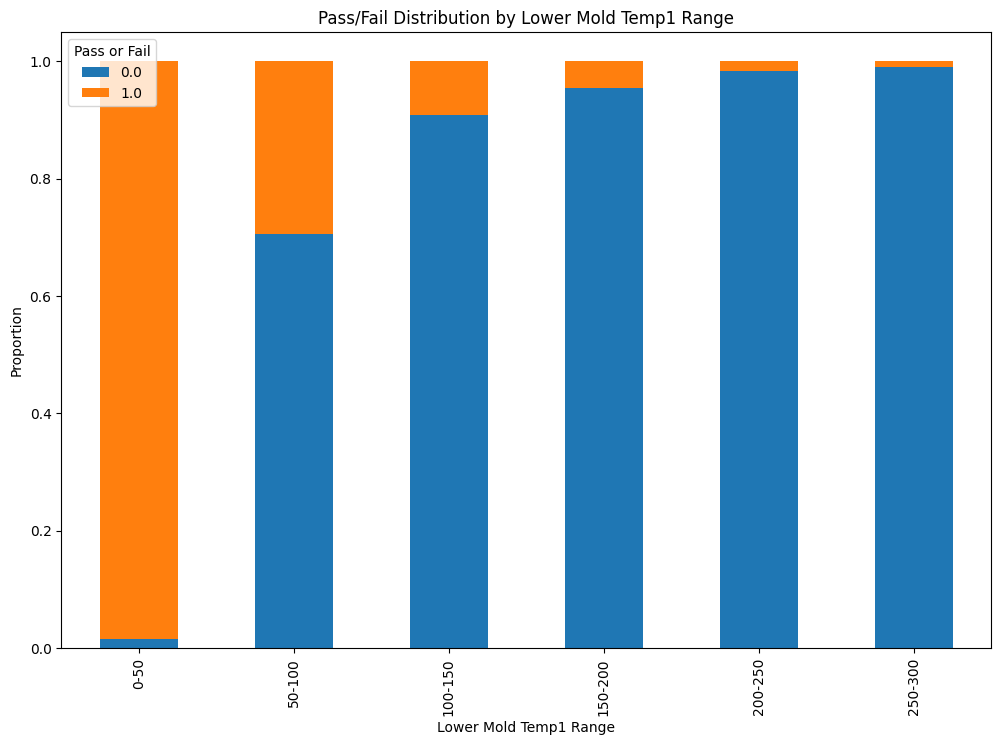

In [77]:
# lower_mold_temp1의 범위 설정
bins = [0, 50, 100, 150, 200, 250, 300]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300']

# lower_mold_temp1을 범위로 변환
data_copy['lower_mold_temp1_range'] = pd.cut(data_copy['lower_mold_temp1'], bins=bins, labels=labels)

# 범위별 passorfail의 비율 계산
passorfail_counts = data_copy.groupby('lower_mold_temp1_range')['passorfail'].value_counts(normalize=True).unstack().fillna(0)

# 범위별 passorfail의 비율 숫자로 출력
passorfail_counts_numeric = data_copy.groupby('lower_mold_temp1_range')['passorfail'].value_counts().unstack().fillna(0)

# 숫자와 비율을 함께 출력
passorfail_summary = pd.concat([passorfail_counts_numeric, passorfail_counts], axis=1, keys=['Counts', 'Proportions'])

print(passorfail_summary)

# 시각화
passorfail_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Pass/Fail Distribution by Lower Mold Temp1 Range')
plt.xlabel('Lower Mold Temp1 Range')
plt.ylabel('Proportion')
plt.legend(title='Pass or Fail')
plt.show()

                    Counts       Proportions          
passorfail             0.0   1.0         0.0       1.0
cast_pressure_range                                   
41-325               17221  2923    0.854895  0.145105
325-329              12587   138    0.989155  0.010845
329-330              20202   359    0.982540  0.017460
330-331              17962   303    0.983411  0.016589
331-332              11849   161    0.986595  0.013405
332-348               8177   132    0.984114  0.015886


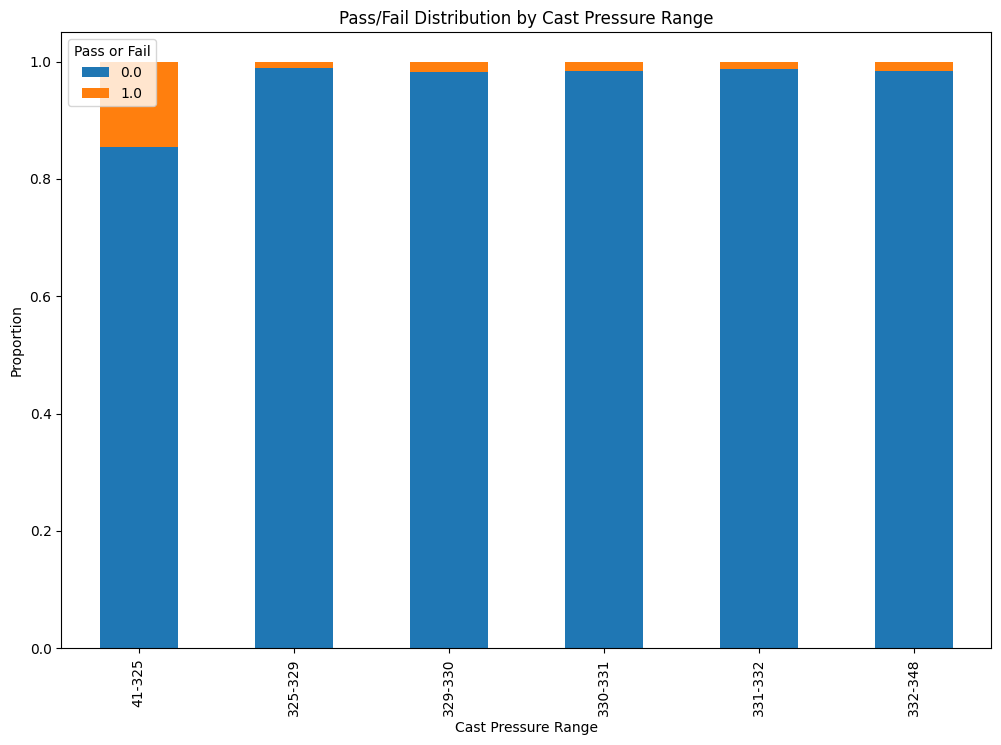

In [78]:
# cast_pressure의 비율을 기반으로 범위 설정 (분위수 기준으로 나누기)
bins = pd.qcut(data_copy['cast_pressure'], q=6, duplicates='drop', retbins=True)[1]
labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

# cast_pressure를 범위로 변환
data_copy['cast_pressure_range'] = pd.cut(data_copy['cast_pressure'], bins=bins, labels=labels, include_lowest=True)

# 범위별 passorfail의 비율 계산
passorfail_counts = data_copy.groupby('cast_pressure_range')['passorfail'].value_counts(normalize=True).unstack().fillna(0)

# 범위별 passorfail의 비율 숫자로 출력
passorfail_counts_numeric = data_copy.groupby('cast_pressure_range')['passorfail'].value_counts().unstack().fillna(0)

# 숫자와 비율을 함께 출력
passorfail_summary = pd.concat([passorfail_counts_numeric, passorfail_counts], axis=1, keys=['Counts', 'Proportions'])

print(passorfail_summary)

# 시각화
passorfail_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Pass/Fail Distribution by Cast Pressure Range')
plt.xlabel('Cast Pressure Range')
plt.ylabel('Proportion')
plt.legend(title='Pass or Fail')
plt.show()

## 2-3. 카이제곱 검정(참고)

In [155]:
import pandas as pd
import scipy.stats as stats

# 교차표 생성
contingency_table = pd.crosstab(data_copy['tryshot_signal'], data_copy['passorfail'])

# 카이제곱 검정 수행
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"카이제곱 통계량: {chi2}")
print(f"p-값: {p}")

# 결과 해석
if p < 0.05:
    print("두 변수 간에 통계적으로 유의미한 상관관계가 있습니다.")
else:
    print("두 변수 간에 통계적으로 유의미한 상관관계가 없습니다.")

카이제곱 통계량: 0.0
p-값: 1.0
두 변수 간에 통계적으로 유의미한 상관관계가 없습니다.


In [81]:
import pandas as pd
import scipy.stats as stats

# 교차표 생성
contingency_table = pd.crosstab(data_copy['working'], data_copy['passorfail'])

# 카이제곱 검정 수행
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"카이제곱 통계량: {chi2}")
print(f"p-값: {p}")

# 결과 해석
if p < 0.05:
    print("두 변수 간에 통계적으로 유의미한 상관관계가 있습니다.")
else:
    print("두 변수 간에 통계적으로 유의미한 상관관계가 없습니다.")

카이제곱 통계량: 1006.4390184285219
p-값: 7.155827151114373e-221
두 변수 간에 통계적으로 유의미한 상관관계가 있습니다.


In [ ]:
import pandas as pd
import scipy.stats as stats

# 교차표 생성
contingency_table = pd.crosstab(data_copy['heating_furnace'], data_copy['passorfail'])

# 카이제곱 검정 수행
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"카이제곱 통계량: {chi2}")
print(f"p-값: {p}")

# 결과 해석
if p < 0.05:
    print("두 변수 간에 통계적으로 유의미한 상관관계가 있습니다.")
else:
    print("두 변수 간에 통계적으로 유의미한 상관관계가 없습니다.")

카이제곱 통계량: 20.320710323636156
p-값: 3.8673530365820754e-05
두 변수 간에 통계적으로 유의미한 상관관계가 있습니다.


In [ ]:
import pandas as pd
import scipy.stats as stats

# 교차표 생성
contingency_table = pd.crosstab(data_copy['registration_time'], data_copy['passorfail'])

# 카이제곱 검정 수행
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"카이제곱 통계량: {chi2}")
print(f"p-값: {p}")

# 결과 해석
if p < 0.05:
    print("두 변수 간에 통계적으로 유의미한 상관관계가 있습니다.")
else:
    print("두 변수 간에 통계적으로 유의미한 상관관계가 없습니다.")

카이제곱 통계량: 91842.96679161747
p-값: 0.37313985977586517
두 변수 간에 통계적으로 유의미한 상관관계가 없습니다.


# 3. 데이터 정제 

In [9]:
data_copy = casting.copy()

- 결측치 비율 확인

In [143]:
# 'molten_volume' 열의 총 개수와 결측치 개수를 계산
total_count = data_copy['molten_volume'].shape[0]
missing_count = data_copy['molten_volume'].isna().sum()

# 결측치 비율 계산
missing_percentage = (missing_count / total_count) *100

# 결측치 비율 출력
print(f"결측치 비율: {missing_percentage:.2f}%")

결측치 비율: 49.05%


In [60]:
# 'physical_strength' 열의 총 개수와 결측치 개수를 계산
total_count = data_copy['physical_strength'].shape[0]
missing_count = data_copy['physical_strength'].isna().sum()

# 결측치 비율 계산
missing_percentage = (missing_count / total_count) *100

# 결측치 비율 출력
print(f"결측치 비율: {missing_percentage:.2f}%")

결측치 비율: 0.00%


In [61]:
# 'lower_mold_temp3' 열의 총 개수와 결측치 개수를 계산
total_count = data_copy['lower_mold_temp3'].shape[0]
missing_count = data_copy['lower_mold_temp3'].isna().sum()

# 결측치 비율 계산
missing_percentage = (missing_count / total_count) *100

# 결측치 비율 출력
print(f"결측치 비율: {missing_percentage:.2f}%")

결측치 비율: 0.34%


In [62]:
# 'upper_mold_temp3' 열의 총 개수와 결측치 개수를 계산
total_count = data_copy['upper_mold_temp3'].shape[0]
missing_count = data_copy['upper_mold_temp3'].isna().sum()

# 결측치 비율 계산
missing_percentage = (missing_count / total_count) *100

# 결측치 비율 출력
print(f"결측치 비율: {missing_percentage:.2f}%")


결측치 비율: 0.34%


## 3-1. 불필요한 값 제거
- 불필요한 컬럼 제거
- null 값 제거 : molten_volume이랑 다른 null값 있는 행 제거

In [96]:
# 'line', 'name', 'mold_name', 'time', 'date', 'emergency_stop','working','heating_furnace' 열 제거
data_copy = data_copy.drop(columns=['line', 'name', 'mold_name', 'time', 'date', 'emergency_stop','working','heating_furnace'])

# 결과 출력
print(data_copy)

       count  molten_temp  facility_operation_cycleTime  production_cycletime  \
0        258        731.0                           119                   120   
1        243        720.0                            98                   125   
2        244        721.0                            98                   122   
3        245        721.0                           100                   125   
4        246        721.0                            99                   123   
...      ...          ...                           ...                   ...   
92010     71        731.0                           122                   122   
92011     72        731.0                           120                   121   
92012     73        732.0                           122                   135   
92013     74        732.0                           133                   122   
92014     75        732.0                           122                   123   

       low_section_speed  h

In [145]:
data_copy.drop('molten_volume', axis=1, inplace=True)
# 'molten_temp', 'upper_mold_temp3', 'lower_mold_temp3' 열에서 결측값을 가진 행을 제거
data_copy.dropna(subset=['molten_temp', 'upper_mold_temp3', 'lower_mold_temp3'], inplace=True)

data_copy.reset_index(drop=True, inplace=True)
data_copy

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,258,731.0,119,120,110.0,112.0,331.0,35.0,198.0,116.0,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,73,731.0,119,120,109.0,125.0,177.0,48.0,24.0,33.0,...,1449.0,479.0,708.0,35.0,23,2019-01-02 17:27:28,1.0,NaN,8722,NaN
2,1,731.0,119,123,109.0,112.0,176.0,49.0,26.0,55.0,...,1449.0,513.0,700.0,35.0,23,2019-01-02 17:29:32,1.0,NaN,8722,NaN
3,2,731.0,119,124,109.0,112.0,331.0,47.0,31.0,65.0,...,1449.0,531.0,708.0,34.0,23,2019-01-02 17:31:41,1.0,NaN,8722,NaN
4,3,731.0,120,124,110.0,112.0,331.0,46.0,36.0,73.0,...,1449.0,544.0,707.0,34.0,23,2019-01-02 17:33:39,1.0,NaN,8722,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89436,71,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,...,1449.0,279.0,726.0,30.0,0,2019-03-31 23:51:29,0.0,NaN,8917,A
89437,72,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,...,1449.0,279.0,732.0,30.0,0,2019-03-31 23:53:28,0.0,NaN,8917,A
89438,73,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,...,1449.0,272.0,731.0,30.0,0,2019-03-31 23:55:44,0.0,NaN,8917,A
89439,74,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,...,1449.0,288.0,723.0,30.0,0,2019-03-31 23:57:46,0.0,NaN,8917,A


## 3-2. 이상치 제거 : peak 값 65505-65535

In [146]:
filtered_data = data_copy[(data_copy['low_section_speed'] >= 50000) | 
                          (data_copy['lower_mold_temp3'] >= 50000) | 
                          (data_copy['physical_strength'] >= 50000)]

# 필터링된 행의 인덱스를 사용하여 원본 데이터프레임에서 해당 인덱스를 삭제
data_copy.drop(index=filtered_data.index, inplace=True)

print(data_copy)

       count  molten_temp  facility_operation_cycleTime  production_cycletime  \
0        258        731.0                           119                   120   
1         73        731.0                           119                   120   
2          1        731.0                           119                   123   
3          2        731.0                           119                   124   
4          3        731.0                           120                   124   
...      ...          ...                           ...                   ...   
89436     71        731.0                           122                   122   
89437     72        731.0                           120                   121   
89438     73        732.0                           122                   135   
89439     74        732.0                           133                   122   
89440     75        732.0                           122                   123   

       low_section_speed  h

## 3-3. 이상치 제거 : 냉각수 온도 이상

In [147]:
import pandas as pd

# 이상치를 판단할 열 선택
column_name = 'Coolant_temperature'

# Z-score 기반 이상치 감지 함수 정의
def detect_outliers(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    outliers = df[(df[column] - mean).abs() > threshold * std]
    return outliers

# 이상치 감지
outliers_df = detect_outliers(data_copy, column_name)

# 이상치 출력
print("이상치:")
print(outliers_df)

이상치:
       count  molten_temp  facility_operation_cycleTime  production_cycletime  \
11541      1        709.0                           118                   132   
11543      2        709.0                           121                   126   
11545      3        709.0                           116                   122   
11549      4        709.0                           118                   122   
11550      5        709.0                           118                   123   
11552      6        709.0                           119                   122   
11554      7        709.0                           119                   122   
11556      8        709.0                           119                   122   
11558      9        709.0                           119                   126   

       low_section_speed  high_section_speed  cast_pressure  \
11541              138.0               144.0          333.0   
11543              140.0               144.0          333.

In [148]:
outliers_df[['registration_time','Coolant_temperature','molten_temp','lower_mold_temp3','upper_mold_temp3']]

,registration_time,Coolant_temperature,molten_temp,lower_mold_temp3,upper_mold_temp3
11541,2019-01-19 00:07:38,1449.0,709.0,1449.0,1449.0
11543,2019-01-19 00:09:45,1449.0,709.0,1449.0,1449.0
11545,2019-01-19 00:11:44,1449.0,709.0,1449.0,1449.0
11549,2019-01-19 00:18:45,1449.0,709.0,1449.0,1449.0
11550,2019-01-19 00:20:48,1449.0,709.0,1449.0,1449.0
11552,2019-01-19 00:22:49,1449.0,709.0,1449.0,1449.0
11554,2019-01-19 00:24:58,1449.0,709.0,1449.0,1449.0
11556,2019-01-19 00:26:49,1449.0,709.0,1449.0,1449.0
11558,2019-01-19 00:29:02,1449.0,709.0,1449.0,1449.0


In [149]:
data_copy.drop(outliers_df.index, inplace=True)

In [150]:
data_copy

,count,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,258,731.0,119,120,110.0,112.0,331.0,35.0,198.0,116.0,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,73,731.0,119,120,109.0,125.0,177.0,48.0,24.0,33.0,...,1449.0,479.0,708.0,35.0,23,2019-01-02 17:27:28,1.0,NaN,8722,NaN
2,1,731.0,119,123,109.0,112.0,176.0,49.0,26.0,55.0,...,1449.0,513.0,700.0,35.0,23,2019-01-02 17:29:32,1.0,NaN,8722,NaN
3,2,731.0,119,124,109.0,112.0,331.0,47.0,31.0,65.0,...,1449.0,531.0,708.0,34.0,23,2019-01-02 17:31:41,1.0,NaN,8722,NaN
4,3,731.0,120,124,110.0,112.0,331.0,46.0,36.0,73.0,...,1449.0,544.0,707.0,34.0,23,2019-01-02 17:33:39,1.0,NaN,8722,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89436,71,731.0,122,122,100.0,101.0,331.0,49.0,83.0,183.0,...,1449.0,279.0,726.0,30.0,0,2019-03-31 23:51:29,0.0,NaN,8917,A
89437,72,731.0,120,121,100.0,101.0,331.0,54.0,83.0,184.0,...,1449.0,279.0,732.0,30.0,0,2019-03-31 23:53:28,0.0,NaN,8917,A
89438,73,732.0,122,135,100.0,101.0,331.0,52.0,79.0,184.0,...,1449.0,272.0,731.0,30.0,0,2019-03-31 23:55:44,0.0,NaN,8917,A
89439,74,732.0,133,122,100.0,101.0,331.0,53.0,82.0,185.0,...,1449.0,288.0,723.0,30.0,0,2019-03-31 23:57:46,0.0,NaN,8917,A


## 3-4. 양품/불량에 따른 heating_furnace 비율 확인

In [157]:
# heating furnace 살림
# 'line', 'name', 'mold_name', 'time', 'date', 'emergency_stop','working', 열 제거
data_heating = data_heating.drop(columns=['line', 'name', 'mold_name', 'time', 'date', 'emergency_stop','working'])

# 결과 출력
print(data_heating)

       count  molten_temp  facility_operation_cycleTime  production_cycletime  \
0        258        731.0                           119                   120   
1        243        720.0                            98                   125   
2        244        721.0                            98                   122   
3        245        721.0                           100                   125   
4        246        721.0                            99                   123   
...      ...          ...                           ...                   ...   
92010     71        731.0                           122                   122   
92011     72        731.0                           120                   121   
92012     73        732.0                           122                   135   
92013     74        732.0                           133                   122   
92014     75        732.0                           122                   123   

       low_section_speed  h

In [158]:
data_heating['heating_furnace']

0        NaN
1          B
2          B
3          B
4          B
        ... 
92010      A
92011      A
92012      A
92013      A
92014      A
Name: heating_furnace, Length: 92015, dtype: object

비율 값:
passorfail            0.0       1.0
heating_furnace                    
A                0.961946  0.038054
B                0.954635  0.045365
NaN              0.954665  0.045335


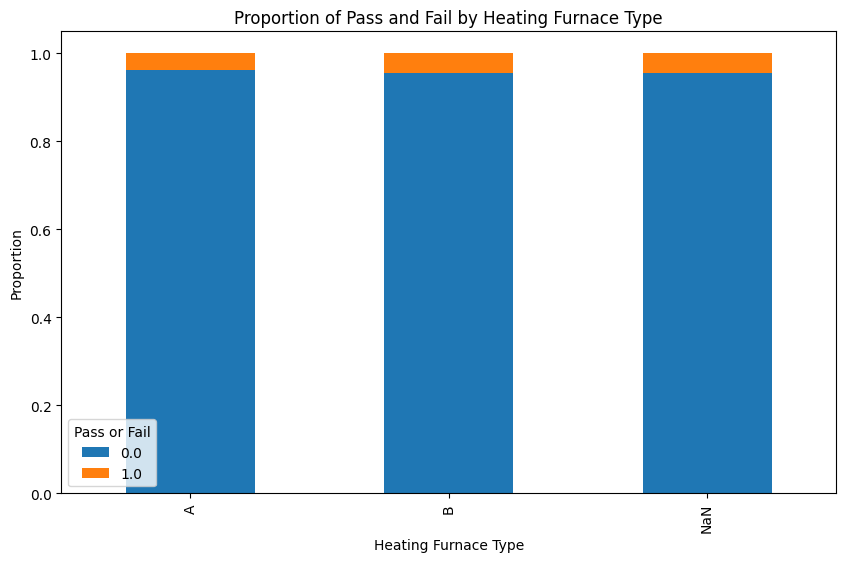

In [159]:

# heating_furnace가 None인 경우를 'NaN'로 변환
data_heating['heating_furnace'].fillna('NaN', inplace=True)

# heating_furnace와 passorfail 값에 따라 그룹화 및 개수 세기
grouped = data_heating.groupby(['heating_furnace', 'passorfail']).size().unstack(fill_value=0)

# 비율 계산 (각 heating_furnace 값에 대해 pass와 fail의 비율)
grouped_ratio = grouped.div(grouped.sum(axis=1), axis=0)

# 비율 값 출력
print("비율 값:")
print(grouped_ratio)

# 시각화
grouped_ratio.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Proportion of Pass and Fail by Heating Furnace Type')
plt.xlabel('Heating Furnace Type')
plt.ylabel('Proportion')
plt.legend(title='Pass or Fail')
plt.show()


In [1]:

# heating_furnace가 'null'인 행 제거 (ANOVA 분석에 포함되지 않도록)
data_copy = data_copy[data_copy['heating_furnace'] != 'null']

# heating_furnace 값에 따라 Coolant_temperature 그룹화
group_A = data_copy[data_copy['heating_furnace'] == 'A']['Coolant_temperature']
group_B = data_copy[data_copy['heating_furnace'] == 'B']['Coolant_temperature']

# ANOVA 테스트 수행
f_statistic, p_value = f_oneway(group_A, group_B)

# 결과 출력
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("유의미한 차이가 있습니다. (귀무 가설 기각)")
else:
    print("유의미한 차이가 없습니다. (귀무 가설 채택)")


NameError: name 'data_copy' is not defined

## 3-5. (데이터 탐색 시 사전 진행) 라벨코딩

In [23]:
# 'tryshot_signal' 열을 수치형으로 변환하고 NaN 값을 0으로 대체
data_copy['tryshot_signal'] = data_copy['tryshot_signal'].map({'D': 1}).fillna(0)

# 결과 출력
print(data_copy)

       count  molten_temp  facility_operation_cycleTime  production_cycletime  \
0        258        731.0                           119                   120   
1         73        731.0                           119                   120   
2          1        731.0                           119                   123   
3          2        731.0                           119                   124   
4          3        731.0                           120                   124   
...      ...          ...                           ...                   ...   
89436     71        731.0                           122                   122   
89437     72        731.0                           120                   121   
89438     73        732.0                           122                   135   
89439     74        732.0                           133                   122   
89440     75        732.0                           122                   123   

       low_section_speed  h

In [27]:
data_copy.shape

(89427, 22)

In [ ]:
# 'working' 열을 수치형으로 변환
data_copy['working'] = data_copy['working'].map({'가동': 1, '정지': 0})

# 결과 출력
print(data_copy)

       count  working  molten_temp  facility_operation_cycleTime  \
0        258        1        731.0                           119   
1        243        1        720.0                            98   
2        244        1        721.0                            98   
3        245        1        721.0                           100   
4        246        1        721.0                            99   
...      ...      ...          ...                           ...   
92010     71        1        731.0                           122   
92011     72        1        731.0                           120   
92012     73        1        732.0                           122   
92013     74        1        732.0                           133   
92014     75        1        732.0                           122   

       production_cycletime  low_section_speed  high_section_speed  \
0                       120              110.0               112.0   
1                       125              10

In [ ]:
data_copy['tryshot_signal'].unique()

array([nan, 'D'], dtype=object)

In [ ]:
# 'tryshot_signal' 열을 수치형으로 변환하고 NaN 값을 0으로 대체
data_copy['tryshot_signal'] = data_copy['tryshot_signal'].map({'D': 1}).fillna(0)

# 결과 출력
print(data_copy)

       count  working  molten_temp  facility_operation_cycleTime  \
0        258        1        731.0                           119   
1        243        1        720.0                            98   
2        244        1        721.0                            98   
3        245        1        721.0                           100   
4        246        1        721.0                            99   
...      ...      ...          ...                           ...   
92010     71        1        731.0                           122   
92011     72        1        731.0                           120   
92012     73        1        732.0                           122   
92013     74        1        732.0                           133   
92014     75        1        732.0                           122   

       production_cycletime  low_section_speed  high_section_speed  \
0                       120              110.0               112.0   
1                       125              10

In [ ]:
data_copy['tryshot_signal'].unique()

array([0., 1.])

In [ ]:
data_copy['heating_furnace'].unique()

array([nan, 'B', 'A'], dtype=object)

In [119]:
# 'heating_furnace' 열을 수치형으로 변환
data_copy['heating_furnace'] = data_copy['heating_furnace'].map({'A': 0, 'B': 1}).fillna(2)

# 결과 출력
print(data_copy)

       count  molten_temp  facility_operation_cycleTime  production_cycletime  \
0        258        731.0                           119                   120   
1        243        720.0                            98                   125   
2        244        721.0                            98                   122   
3        245        721.0                           100                   125   
4        246        721.0                            99                   123   
...      ...          ...                           ...                   ...   
92010     71        731.0                           122                   122   
92011     72        731.0                           120                   121   
92012     73        732.0                           122                   135   
92013     74        732.0                           133                   122   
92014     75        732.0                           122                   123   

       low_section_speed  h

In [120]:
data_copy['heating_furnace']

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
92010    2.0
92011    2.0
92012    2.0
92013    2.0
92014    2.0
Name: heating_furnace, Length: 92000, dtype: float64

In [ ]:
# 'registration_time' 열을 datetime 형식으로 변환
data_copy['registration_time'] = pd.to_datetime(data_copy['registration_time'])

# 결과 출력
print(data_copy)

       count  working  molten_temp  facility_operation_cycleTime  \
0        258        1        731.0                           119   
1        243        1        720.0                            98   
2        244        1        721.0                            98   
3        245        1        721.0                           100   
4        246        1        721.0                            99   
...      ...      ...          ...                           ...   
92010     71        1        731.0                           122   
92011     72        1        731.0                           120   
92012     73        1        732.0                           122   
92013     74        1        732.0                           133   
92014     75        1        732.0                           122   

       production_cycletime  low_section_speed  high_section_speed  \
0                       120              110.0               112.0   
1                       125              10

## 3-6. 관계비교

- 범주형,연속형 상관계수 비교

- heating_furnace : 0(null) / 1(A) / 2(B)
- heating_furnace 가 0일 때 양품/불량 비율

In [89]:
data_copy

,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,...,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace,lower_mold_temp1_range,cast_pressure_range,upper_mold_temp1_range
0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:06,258,가동,ON,731.0,119,...,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN,200-250,330-331,150-200
1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:08,243,가동,ON,720.0,98,...,30.0,25,2019-01-02 16:45:08,0.0,NaN,8412,B,200-250,41-325,200-250
2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:58,244,가동,ON,721.0,98,...,30.0,25,2019-01-02 16:45:58,0.0,NaN,8412,B,200-250,41-325,200-250
3,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:48:03,245,가동,ON,721.0,100,...,30.0,25,2019-01-02 16:48:03,0.0,NaN,8412,B,200-250,41-325,250-300
4,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:50:08,246,가동,ON,721.0,99,...,30.0,25,2019-01-02 16:50:08,0.0,NaN,8412,B,200-250,41-325,250-300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:51:29,71,가동,ON,731.0,122,...,30.0,0,2019-03-31 23:51:29,0.0,NaN,8917,A,200-250,330-331,50-100
92011,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:53:28,72,가동,ON,731.0,120,...,30.0,0,2019-03-31 23:53:28,0.0,NaN,8917,A,200-250,330-331,50-100
92012,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:55:44,73,가동,ON,732.0,122,...,30.0,0,2019-03-31 23:55:44,0.0,NaN,8917,A,200-250,330-331,50-100
92013,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-03-31,23:57:46,74,가동,ON,732.0,133,...,30.0,0,2019-03-31 23:57:46,0.0,NaN,8917,A,200-250,330-331,50-100


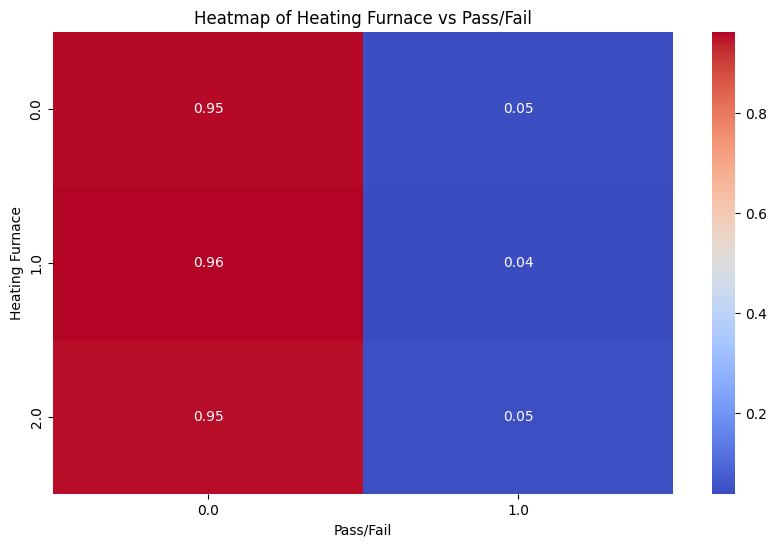

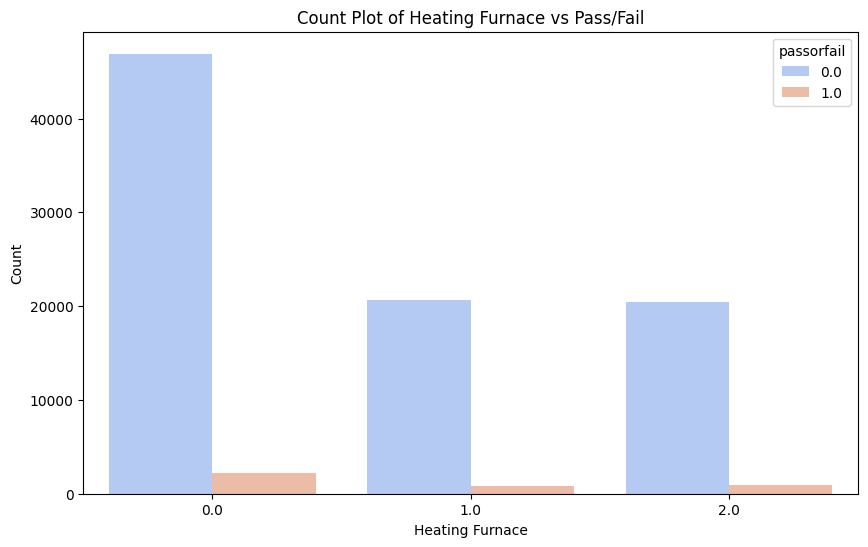

In [ ]:
# 관계 시각화 (히트맵)
cross_tab = pd.crosstab(data_copy['heating_furnace'], data_copy['passorfail'], normalize='index')

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Heating Furnace vs Pass/Fail')
plt.xlabel('Pass/Fail')
plt.ylabel('Heating Furnace')
plt.show()

# 비율 시각화 (카운트 플롯)
plt.figure(figsize=(10, 6))
sns.countplot(x='heating_furnace', hue='passorfail', data=data_copy, palette='coolwarm')
plt.title('Count Plot of Heating Furnace vs Pass/Fail')
plt.xlabel('Heating Furnace')
plt.ylabel('Count')
plt.show()

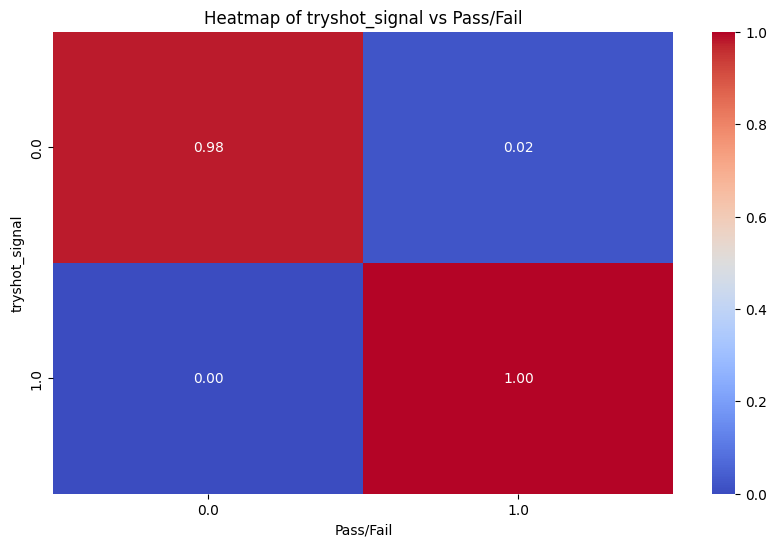

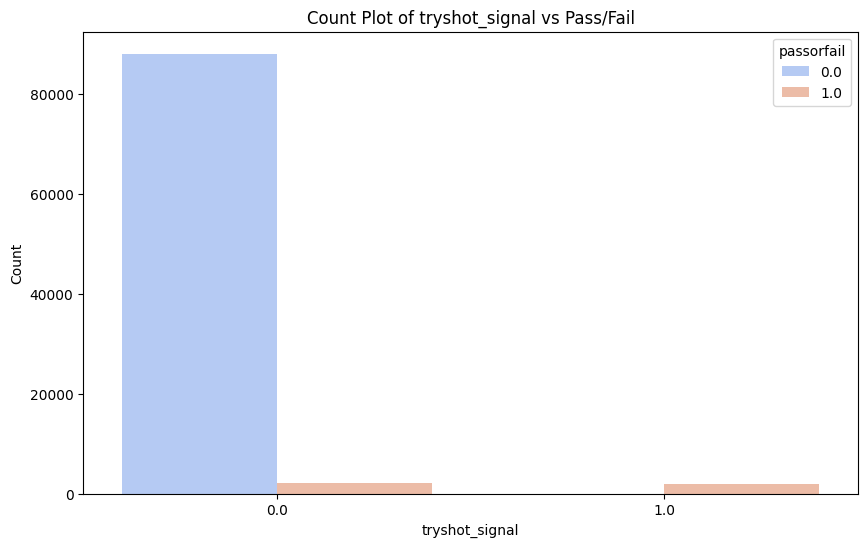

In [ ]:
# 관계 시각화 (히트맵) : 불량 중에 null로 나오는 값이 있음
cross_tab = pd.crosstab(data_df['tryshot_signal'], data_df['passorfail'], normalize='index')

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of tryshot_signal vs Pass/Fail')
plt.xlabel('Pass/Fail')
plt.ylabel('tryshot_signal')
plt.show()

# 비율 시각화 (카운트 플롯)
plt.figure(figsize=(10, 6))
sns.countplot(x='tryshot_signal', hue='passorfail', data=data_df, palette='coolwarm')
plt.title('Count Plot of tryshot_signal vs Pass/Fail')
plt.xlabel('tryshot_signal')
plt.ylabel('Count')
plt.show()

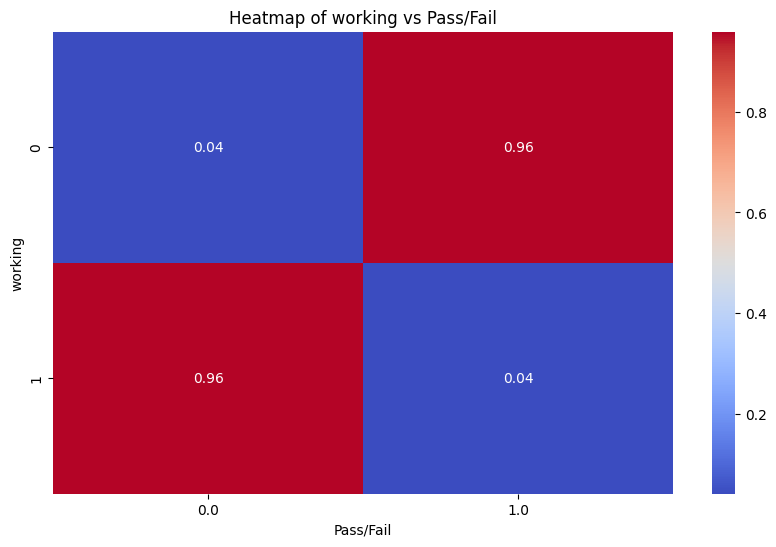

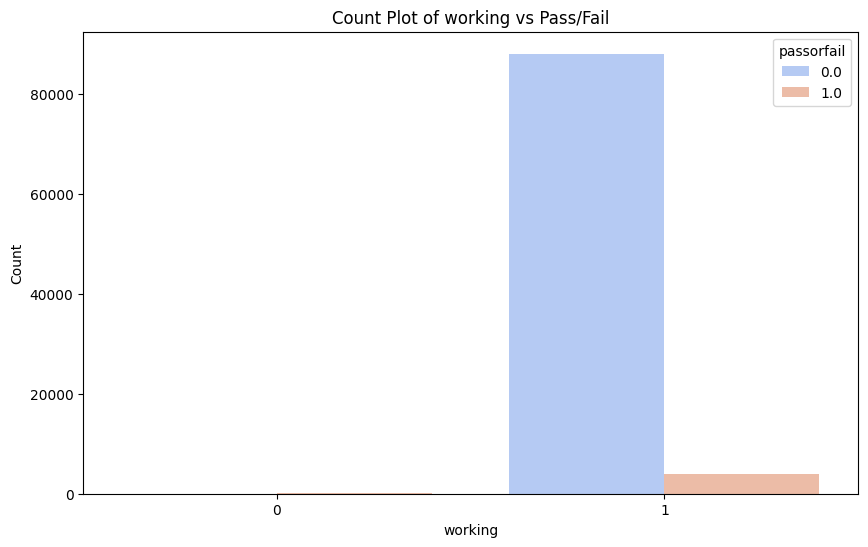

In [ ]:
# 관계 시각화 (히트맵) : 정지(0)했는데 양품(0)이 나온게 0.04, 가동(1)했는데 불량(1)인게 0.04
cross_tab = pd.crosstab(data_copy['working'], data_copy['passorfail'], normalize='index')

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of working vs Pass/Fail')
plt.xlabel('Pass/Fail')
plt.ylabel('working')
plt.show()

# 비율 시각화 (카운트 플롯)
plt.figure(figsize=(10, 6))
sns.countplot(x='working', hue='passorfail', data=data_copy, palette='coolwarm')
plt.title('Count Plot of working vs Pass/Fail')
plt.xlabel('working')
plt.ylabel('Count')
plt.show()

In [ ]:
# 가동 시 불량/양품 비율
# 정지 시 불량/양품 비율

# working 값이 0일 때 passorfail 값의 비율
working_0 = data_copy[data_copy['working'] == 0]['passorfail'].value_counts(normalize=True)
print("Working 값이 0일 때 passorfail 값의 비율:")
print(working_0)

# working 값이 1일 때 passorfail 값의 비율
working_1 = data_copy[data_copy['working'] == 1]['passorfail'].value_counts(normalize=True)
print("Working 값이 1일 때 passorfail 값의 비율:")
print(working_1)


Working 값이 0일 때 passorfail 값의 비율:
passorfail
1.0    0.959184
0.0    0.040816
Name: proportion, dtype: float64
Working 값이 1일 때 passorfail 값의 비율:
passorfail
0.0    0.956933
1.0    0.043067
Name: proportion, dtype: float64


In [ ]:
# working 값이 0일 때 passorfail 값의 비율과 개수
working_0_counts = data_copy[data_copy['working'] == 0]['passorfail'].value_counts()
working_0_ratios = data_copy[data_copy['working'] == 0]['passorfail'].value_counts(normalize=True)
working_0_summary = pd.DataFrame({'Count': working_0_counts, 'Ratio': working_0_ratios})

print("Working 값이 0(중지)일 때 passorfail 값의 비율과 개수:")
print(working_0_summary)

# working 값이 1일 때 passorfail 값의 비율과 개수
working_1_counts = data_copy[data_copy['working'] == 1]['passorfail'].value_counts()
working_1_ratios = data_copy[data_copy['working'] == 1]['passorfail'].value_counts(normalize=True)
working_1_summary = pd.DataFrame({'Count': working_1_counts, 'Ratio': working_1_ratios})

print("\nWorking 값이 1(가동)일 때 passorfail 값의 비율과 개수:")
print(working_1_summary)


Working 값이 0(중지)일 때 passorfail 값의 비율과 개수:
            Count     Ratio
passorfail                 
1.0            47  0.959184
0.0             2  0.040816

Working 값이 1(가동)일 때 passorfail 값의 비율과 개수:
            Count     Ratio
passorfail                 
0.0         87990  0.956933
1.0          3960  0.043067


## 3-7. 상관계수 : 다중공선성 확인용

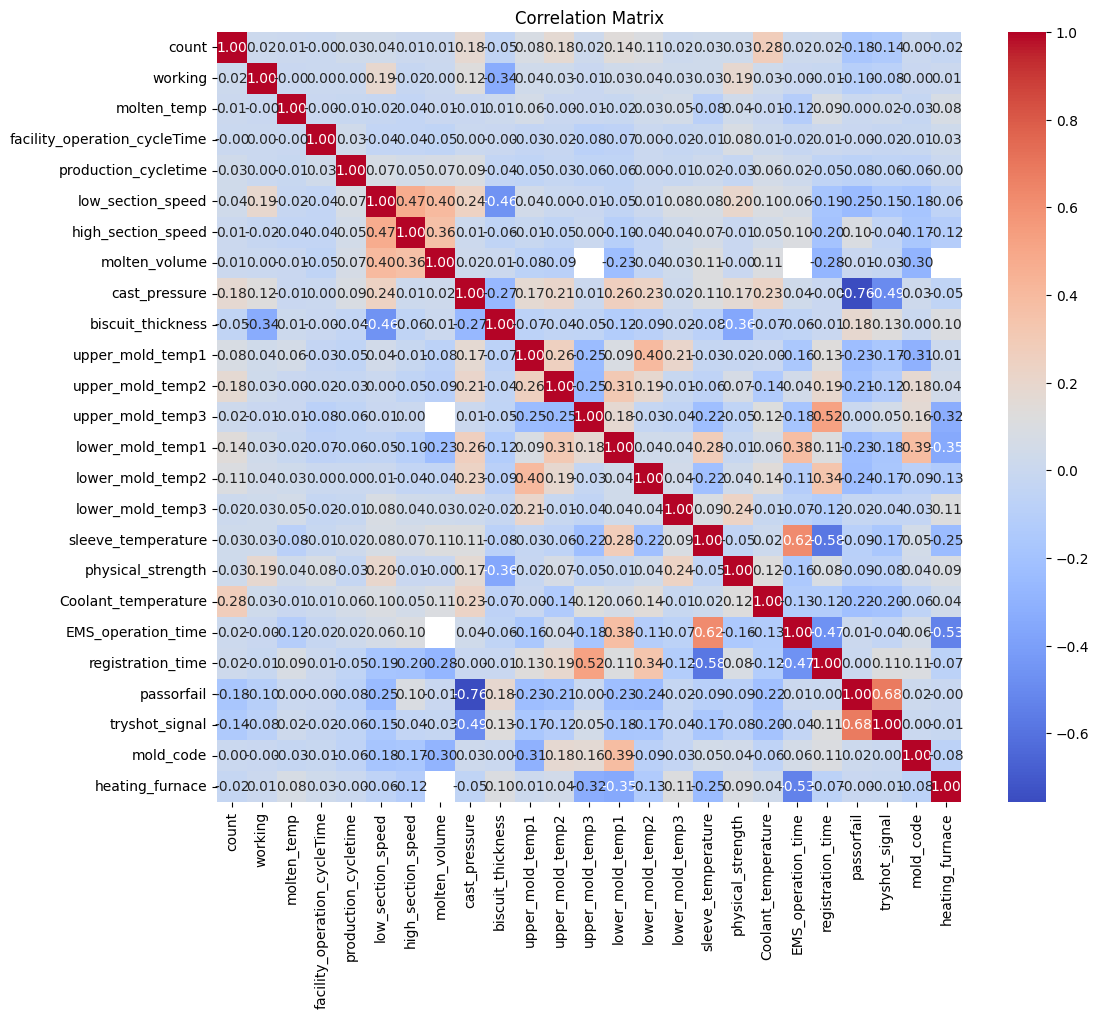

passorfail                      1.000000
tryshot_signal                  0.683785
biscuit_thickness               0.184543
high_section_speed              0.098284
mold_code                       0.017584
EMS_operation_time              0.008176
molten_temp                     0.002926
upper_mold_temp3                0.000942
registration_time               0.000183
heating_furnace                -0.002614
facility_operation_cycleTime   -0.004594
molten_volume                  -0.005118
lower_mold_temp3               -0.023631
production_cycletime           -0.076234
physical_strength              -0.089368
sleeve_temperature             -0.092596
working                        -0.103560
count                          -0.177777
upper_mold_temp2               -0.207103
Coolant_temperature            -0.218012
upper_mold_temp1               -0.228498
lower_mold_temp1               -0.230759
lower_mold_temp2               -0.240598
low_section_speed              -0.254755
cast_pressure   

In [ ]:
# 상관계수 행렬 계산
correlation_matrix = data_copy.corr()

# Y와의 상관관계 확인
correlation_with_y = correlation_matrix["passorfail"].sort_values(ascending=False)

# 상관관계 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Y와 다른 변수들의 상관관계 출력
correlation_with_y

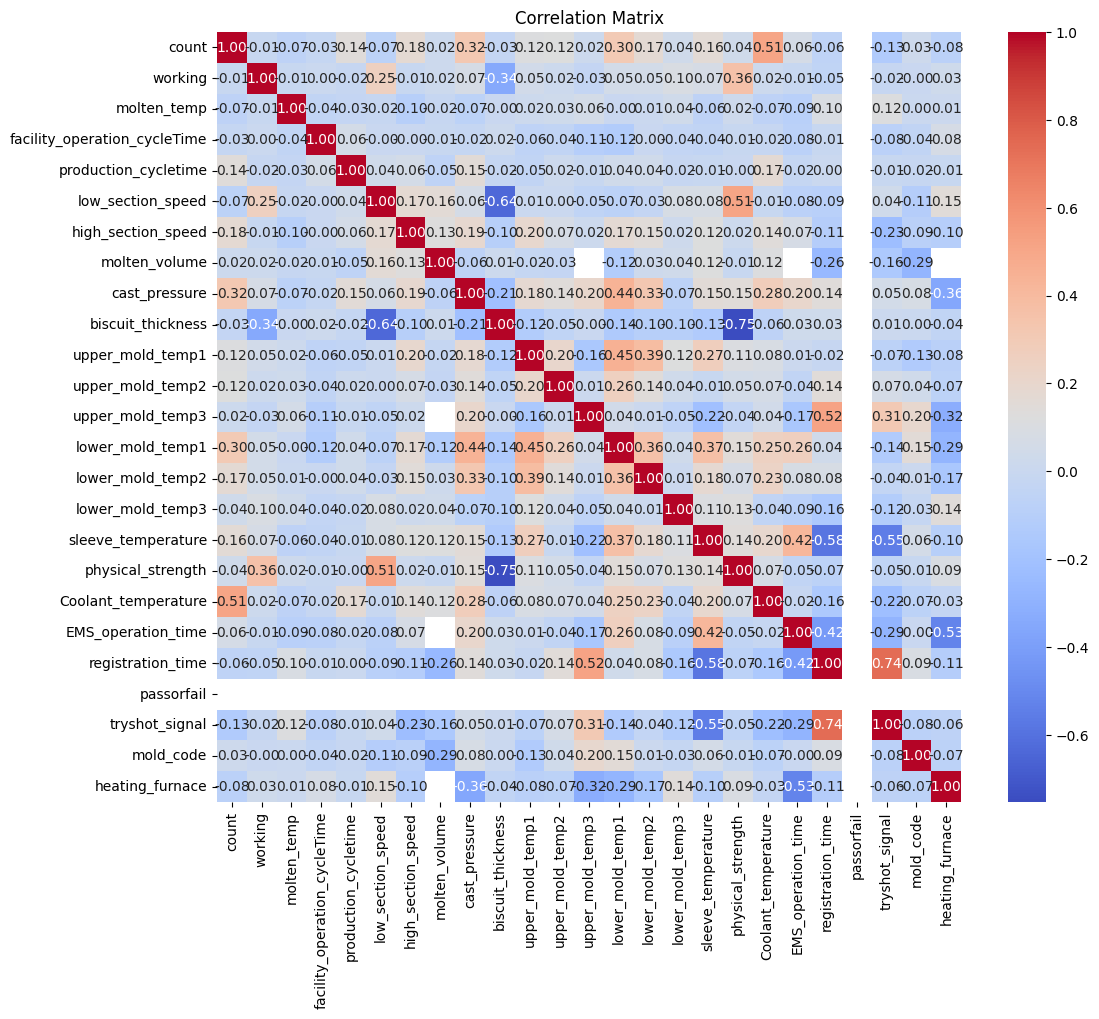

count                          NaN
working                        NaN
molten_temp                    NaN
facility_operation_cycleTime   NaN
production_cycletime           NaN
low_section_speed              NaN
high_section_speed             NaN
molten_volume                  NaN
cast_pressure                  NaN
biscuit_thickness              NaN
upper_mold_temp1               NaN
upper_mold_temp2               NaN
upper_mold_temp3               NaN
lower_mold_temp1               NaN
lower_mold_temp2               NaN
lower_mold_temp3               NaN
sleeve_temperature             NaN
physical_strength              NaN
Coolant_temperature            NaN
EMS_operation_time             NaN
registration_time              NaN
passorfail                     NaN
tryshot_signal                 NaN
mold_code                      NaN
heating_furnace                NaN
Name: passorfail, dtype: float64

In [ ]:
# 'passorfail'이 1(불량)인 데이터 선택
filtered_df = data_copy[data_copy['passorfail'] == 1]

# 상관 행렬 계산
correlation_matrix = filtered_df.corr()

# Y와의 상관관계 확인
correlation_with_y = correlation_matrix["passorfail"].sort_values(ascending=False)

# 상관관계 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Y와 다른 변수들의 상관관계 출력
correlation_with_y